# Noiseless VQE Simulation of Trihydrogen Cation (H₃⁺)

This notebook applies the **Variational Quantum Eigensolver (VQE)** algorithm to compute the **ground state energy of the trihydrogen cation (H₃⁺)** using a **noiseless quantum simulator** and an **ansatz including both single and double excitations**. The simulation is implemented using PennyLane’s quantum chemistry tools.

### Key Features:
- **Molecular Setup**: Builds the H₃⁺ geometry and generates the qubit-based molecular Hamiltonian using the STO-3G basis.
- **Ansatz Construction**: Combines **single and double excitations** following the UCCSD framework.
- **Optimization Strategy**: Uses the **Adam optimizer** to iteratively minimize the expectation value of the Hamiltonian.
- **Results Visualization**:
  - Convergence plot of energy vs. iteration.
  - Quantum state decomposition into basis states and amplitudes.
  - Bar plot of the most significant basis states in the final statevector.

### Purpose:
To simulate the ground state of trihydrogen cation using a fully unitary coupled cluster approach in a **noiseless setting**, offering a reference baseline for:
- Comparing single vs. double excitation contributions,
- Evaluating optimizer performance,

In [1]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD ansatz
import matplotlib.pyplot as plt
import os
from vqe_utils import excitation_ansatz, get_optimizer, set_seed  # helpers

set_seed(0)                              # Reproducible runs
IMG_DIR = "images"                       # Single image directory used repo-wide
os.makedirs(IMG_DIR, exist_ok=True)

In [2]:
# Define the atoms in the trihydrogen cation (H₃⁺)
symbols = ["H", "H", "H"]

# Define coordinates (in Ångströms)
# Approximate equilateral triangle configuration
coordinates = np.array([
    [0.000000,  1.000000,  0.000000],   # Hydrogen 1
    [-0.866025, -0.500000, 0.000000],   # Hydrogen 2
    [ 0.866025, -0.500000, 0.000000]    # Hydrogen 3
])

# Define the H₃⁺ Hamiltonian and the number of qubits required
# Default STO-3G basis set; note the +1 charge
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=+1)

# Each hydrogen has 1 orbital; total of 3 orbitals → 6 spin orbitals → 6 qubits
print(f"{qubits} qubits required")

6 qubits required


In [3]:
# Which orbitals are occupied (1) or unoccupied (0) in the mean-field (Hartree-Fock) solution
electrons = 2  # Total electrons in H₃⁺
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)

# Print the state in bra-ket notation (leftmost bit = highest-index spin orbital)
print(f"Hartree-Fock state: {'|' + ''.join(str(bit) for bit in hf) + '⟩'}")

Hartree-Fock state: |110000⟩


In [4]:
# Define the number of required quantum wires / logical qubits
num_wires = qubits

# Create quantum device simulator backend
dev = qml.device("default.qubit",  # Noiseless state vector simulator
                 wires=num_wires)


@qml.qnode(dev)  # Transforms exp_energy below into a quantum node
def exp_energy(state):
    qml.BasisState(np.array(state), wires=range(num_wires))

    # Return the expectation value of the molecular Hamiltonian
    return qml.expval(hamiltonian)

# Calculate ⟨ψ_hf| hamiltonian |ψ_hf⟩ in Hartree (Ha) units
# 1 Ha = 27.2 eV
exp_energy(hf)

tensor(-1.24436506, requires_grad=True)


Running VQE with single excitations...

Running VQE with double excitations...

Running VQE with both excitations...


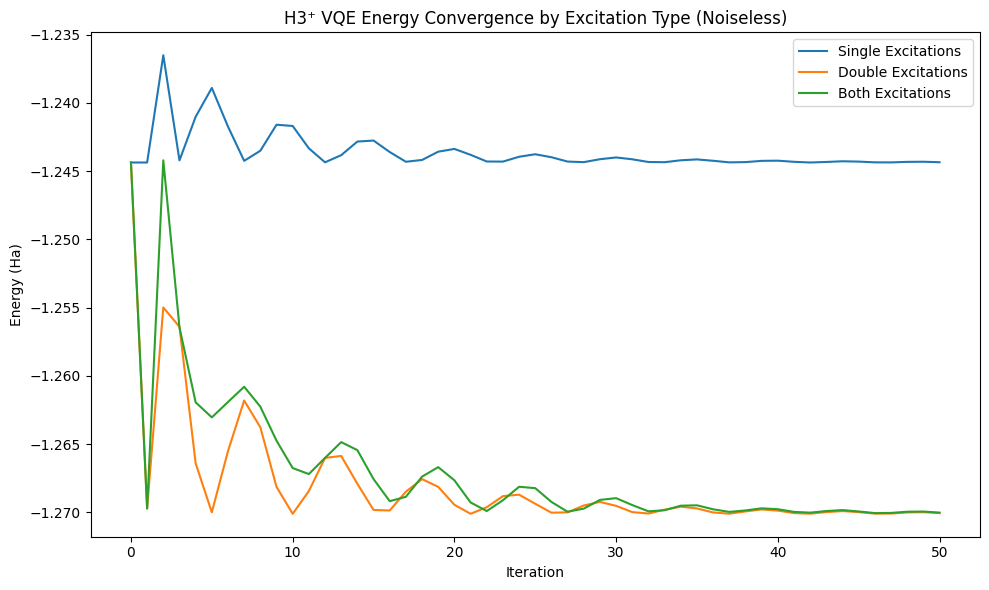

In [5]:
# Generate excitation indices for H₃⁺
singles, doubles = excitations(electrons, qubits)

# Convert excitation indices from lists to tuples (required by PennyLane)
singles = [tuple(ex) for ex in singles]
doubles = [tuple(ex) for ex in doubles]


# General-purpose cost function for single/double/both excitations
def get_cost_function(excitation_type):
    @qml.qnode(dev)
    def cost_fn(params):
        if excitation_type == "single":
            selected_excitations = (singles, [])
        elif excitation_type == "double":
            selected_excitations = ([], doubles)
        else:
            selected_excitations = (singles, doubles)

        excitation_ansatz(
            params,
            wires=range(num_wires),
            hf_state=hf,
            excitations=selected_excitations,
            excitation_type=excitation_type
        )

        return qml.expval(hamiltonian)
    
    return cost_fn

# Compare single, double, and both excitations using Adam optimizer
excitation_types = ["single", "double", "both"]
results = {}
max_iterations = 50

for exc_type in excitation_types:
    print(f"\nRunning VQE with {exc_type} excitations...")
    cost_fn = get_cost_function(exc_type)

    # Set parameter count based on excitation type
    if exc_type == "single":
        n_params = len(singles)
    elif exc_type == "double":
        n_params = len(doubles)
    else:
        n_params = len(singles) + len(doubles)

    params = np.zeros(n_params, requires_grad=True)
    energy = [cost_fn(params)]
    opt = get_optimizer("Adam", stepsize=0.2)

    for _ in range(max_iterations):
        params, _ = opt.step_and_cost(cost_fn, params)
        energy.append(cost_fn(params))

    results[exc_type] = {"energy": energy, "params": params}

# Plot convergence for each excitation type
plt.figure(figsize=(10, 6))
for exc_type in excitation_types:
    plt.plot(results[exc_type]["energy"], label=f"{exc_type.capitalize()} Excitations")

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H3⁺ VQE Energy Convergence by Excitation Type (Noiseless)")
plt.legend()
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3+_Excitation_Comparison.png", dpi=300)
plt.show()

------------------------------------------------------------------------------------------

Final energy (single): -1.24434441 Ha
Final single excitation parameters: [-0.00765239  0.          0.00765239  0.        ]
Final double excitation parameters: []

Ground state of H₃⁺ with single excitations:
|ψ⟩ = 1.0000|110000⟩
------------------------------------------------------------------------------------------

Final energy (double): -1.27005538 Ha
Final single excitation parameters: []
Final double excitation parameters: [0.16984581 0.         0.         0.17069831]

Ground state of H₃⁺ with double excitations:
|ψ⟩ = -0.0849|000011⟩ + -0.0848|001100⟩ + 0.9928|110000⟩
------------------------------------------------------------------------------------------

Final energy (both): -1.27001939 Ha
Final single excitation parameters: [-0.00757033  0.          0.00757033  0.        ]
Final double excitation parameters: [0.16441542 0.         0.         0.17736866]

Ground state of H₃⁺ with bo

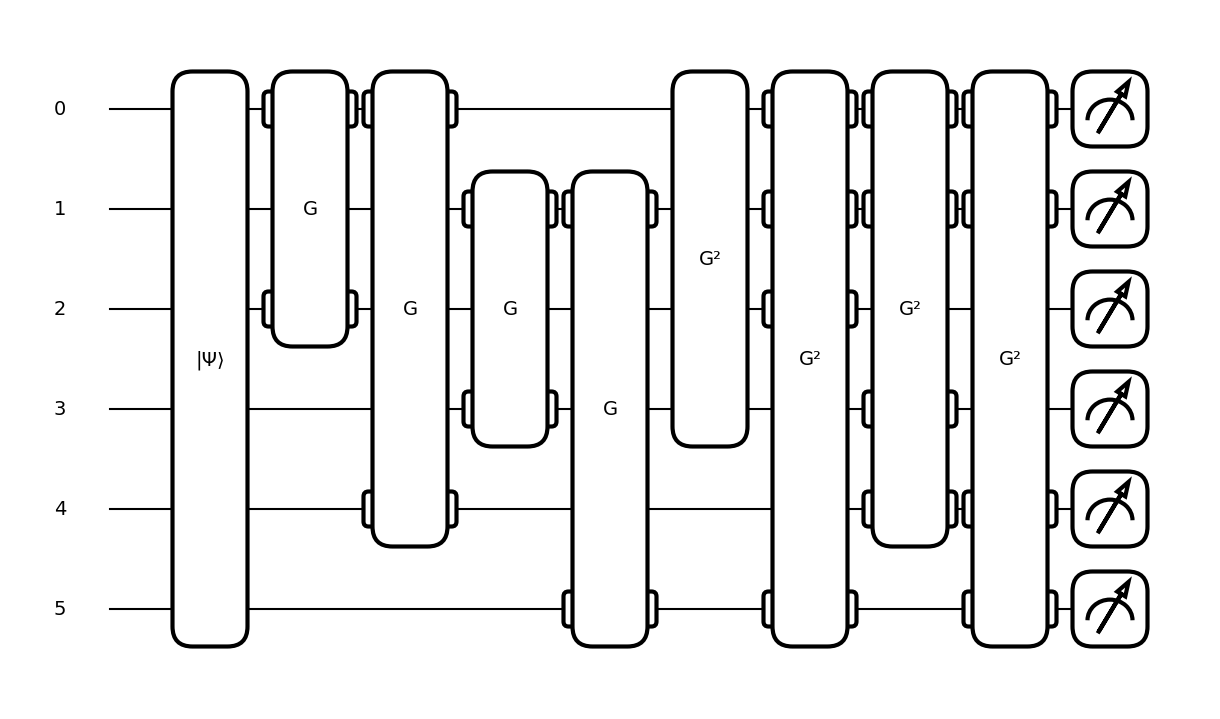

In [6]:
# Define a helper to construct a fresh QNode for each excitation type
def get_ground_state_qnode(excitation_type, selected_excitations):
    @qml.qnode(dev)
    def circuit(params):
        excitation_ansatz(
            params,
            wires=range(num_wires),
            hf_state=hf,
            excitations=selected_excitations,
            excitation_type=excitation_type
        )
        return qml.state()
    return circuit

# Print final energies and ground states for each excitation type
for exc_type in excitation_types:
    final_E = results[exc_type]["energy"][-1]
    final_params = results[exc_type]["params"]

    print("-" * 90)
    print(f"\nFinal energy ({exc_type}): {final_E:.8f} Ha")

    # Split parameters and define excitations
    if exc_type == "single":
        theta_singles = final_params
        theta_doubles = np.array([])
        selected_excitations = (singles, [])
    elif exc_type == "double":
        theta_singles = np.array([])
        theta_doubles = final_params
        selected_excitations = ([], doubles)
    else:
        num_singles = len(singles)
        theta_singles = final_params[:num_singles]
        theta_doubles = final_params[num_singles:]
        selected_excitations = (singles, doubles)

    print(f"Final single excitation parameters: {theta_singles}")
    print(f"Final double excitation parameters: {theta_doubles}")

    # Build and evaluate the correct ground state QNode
    ground_state = get_ground_state_qnode(exc_type, selected_excitations)

    # Evaluate the statevector
    final_state = ground_state(final_params)

    # Extract non-zero amplitude basis states
    threshold = 1e-2
    non_zero_indices = np.where(np.abs(final_state) > threshold)[0]
    non_zero_amplitudes = final_state[non_zero_indices]

    # Print ket notation
    ket_terms = []
    for idx, amp in zip(non_zero_indices, non_zero_amplitudes):
        binary_state = f"|{idx:0{num_wires}b}⟩"
        amp_str = f"{amp.real:.4f}" if np.isclose(amp.imag, 0, atol=1e-6) else f"({amp.real:.4f} + {amp.imag:.4f}j)"
        ket_terms.append(f"{amp_str}{binary_state}")
    ket_notation = " + ".join(ket_terms)

    print(f"\nGround state of H₃⁺ with {exc_type} excitations:\n|ψ⟩ = {ket_notation}")

    # ─── Only draw circuit for "both" excitations ───
    if exc_type == "both":
        print("-" * 90)
        print("\nCircuit diagram for UCCSD:")
        fig, ax = qml.draw_mpl(ground_state)(final_params)
        fig.savefig(f"{IMG_DIR}/H3+_UCCSD_Circuit.png", dpi=300, bbox_inches="tight")